# Retrieval & generation  with llama Stack & Milvus on wx.data


#### Prerequests

Run llama-stack (in version 0.3.0) server with watsonx distribution in terminal
```
llama stack list-deps watsonx | xargs -L1 uv pip install
uv run llama stack run watsonx
```

Add environment variables
- **WATSONX_PROJECT_ID**
- **WATSONX_BASE_URL**
- **WATSONX_API_KEY**


> [!WARNING]
> The llama-stack with version 0.3.2 does not support the embedding models from providers. Possible complication after upgrading the llama stack.
>
>
>
Documents embeded and added to a the Milvus collection - (see Indexing notebook wwith llama stack)


#### Import dependencies


In [ ]:
import os
from dotenv import load_dotenv
from face.helpers import DEFAULT_CONTEXT
from transformers.models.janus.processing_janus import DEFAULT_SYSTEM_PROMPT

load_dotenv()

from llama_stack_client import LlamaStackClient
from llama_stack_client.types import UserMessage, SystemMessage

#### Create LlamaStackClient object


In [3]:
base_url = os.getenv("REMOTE_BASE_URL", "http://localhost:8321")

client = LlamaStackClient(base_url=base_url)


#### Models used in the example

In [4]:
EMBEDDING_MODEL = "ibm/slate-125m-english-rtrvr-v2"
EMBEDDING_MODEL_DIMENSION = 768
LLM_MODEL = "meta-llama/llama-3-3-70b-instruct"

### Files used in the example

In [5]:
from pathlib import Path
import json


In [6]:
docs_folder_path = Path("../")
benchmark_qa_path = docs_folder_path.joinpath("ibm_annual_report_pdf_benchmarking_data.json")

In [7]:
benchmark_qa = json.loads(benchmark_qa_path.read_bytes())
benchmark_qa[:3]

[{'correct_answer_document_ids': ['ibm-annual-report-2024-pt1_1-20.pdf'],
  'question': 'What was the operating other income and expense in 2024?',
  'correct_answer': '$1,656 million'},
 {'correct_answer_document_ids': ['ibm-annual-report-2024-pt1_1-20.pdf'],
  'question': 'What is the amount of gain on land/building dispositions included in "Other"',
  'correct_answer': '$126 million'},
 {'correct_answer_document_ids': ['ibm-annual-report-2024-pt1_1-20.pdf'],
  'question': 'How much was the non-operating retirement-related costs in the current-year period?',
  'correct_answer': '$3,457 million'}]

### Build Inference "AI Service "

In [8]:
vector_store_id = "vs_62b774e4-1dda-4203-a8c7-18db45b0e947"


In [9]:
DEFAULT_PROMPT_TEMPLATE = "{reference_documents}\n[conversation]: {question}. Answer with no more than 150 words. If you cannot base your answer on the given document, please state that you do not have an answer. Respond exclusively in the language of the question, regardless of any other language used in the provided context. Ensure that your entire response is in the same language as the question.\n"

DEFAULT_CONTEXT_TEMPLATE = "[document]: {document}\n"

DEFAULT_SYSTEM_PROMPT = "You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.\nIf a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don’t know the answer to a question, please don’t share false information.\n"

In [10]:
example_question = benchmark_qa[-1].get("question")
example_question

'What was the total revenue for year 2024?'

### Build UserMessage Prompt

In [11]:
def build_prompt(
        question: str,
        reference_documents: list[str]=None,
        prompt_template_text: str = DEFAULT_PROMPT_TEMPLATE,
        context_template_text: str = DEFAULT_CONTEXT_TEMPLATE,
) -> str:
    """
    Warning: It's simplified prompt builder, without sampling of the reference documents
    """
    if reference_documents:
        reference_documents = [
            context_template_text.format(document=reference_document)
            for reference_document in reference_documents
        ]
    else:
        reference_documents = []
    prompt_variables = {
        "question": question,
        "reference_documents": "\n".join(reference_documents)
    }
    return prompt_template_text.format(**prompt_variables)

In [12]:
sample_prompt = build_prompt(question=example_question)
sample_prompt

'\n[conversation]: What was the total revenue for year 2024?. Answer with no more than 150 words. If you cannot base your answer on the given document, please state that you do not have an answer. Respond exclusively in the language of the question, regardless of any other language used in the provided context. Ensure that your entire response is in the same language as the question.\n'

### 1.  Simple apprach - sequential

In [13]:
search_response = client.vector_stores.search(
    vector_store_id=vector_store_id,
    query=example_question,
    search_mode="hybrid",  # other values: vector, keyword
    max_num_results=5,
)
search_response.model_dump()


INFO:httpx:HTTP Request: POST http://127.0.0.1:8321/v1/vector_stores/vs_62b774e4-1dda-4203-a8c7-18db45b0e947/search "HTTP/1.1 200 OK"


{'data': [{'content': [{'text': 'h q u a r t e r t o a s s e s s t h e a d e q u a c y o f t h e e s t i m a t e s . I f t h e e s t i m a t e s w e r e\nc h a n g e d b y 1 0 p e r c e n t i n 2 0 2 4 , t h e i m p a c t o n n e t i n c o m e w o u l d h a v e b e e n $ 3 1 m i l l i o n .\nC o s t s t o C o m p l e t e S e r v i c e C o n t r a c t s\nW e e n t e r i n t o n u m e r o u s s e r v i c e c o n t r a c t s t h r o u g h o u r s e r v i c e s b u s i n e s s e s . D u r i n g t h e c o n t r a c t u a l p e r i o d ',
     'type': 'text'}],
   'file_id': 'ibm-annual-report-2024-pt2_20-40.pdf',
   'filename': '',
   'score': 0.016393441706895828,
   'attributes': {'document_id': 'ibm-annual-report-2024-pt2_20-40.pdf',
    'description': 'Annual Report from IBM '}},
  {'content': [{'text': '- t o - Y r .\nP e r c e n t\nC h a n g e\nI n t e l l e c t u a l p r o p e r t y i n c o m e\n( 1 ) ( 2 )\n$ 3 2 9 $ 3 7 4 ( 1 2 . 1 ) %\nC u s t o m d e v e l o p m e n t i n c o m e

In [14]:
reference_documents = [doc.content[0].text for doc in search_response.data]
len(reference_documents)

5

In [15]:
user_prompt = build_prompt(question=example_question, reference_documents=reference_documents)

In [16]:
response_chat = client.chat.completions.create(
    model=LLM_MODEL,
    messages=[SystemMessage(role="system", content=DEFAULT_SYSTEM_PROMPT), UserMessage(role="user", content=user_prompt)]
)
answer = response_chat.choices[0].message.content
answer

INFO:httpx:HTTP Request: POST http://127.0.0.1:8321/v1/chat/completions "HTTP/1.1 200 OK"


'I do not have an answer to the total revenue for year 2024 as the document does not provide a clear statement of the total revenue for that specific year. The document mentions various financial figures, such as intellectual property income, custom development income, and financing revenue, but it does not provide a comprehensive total revenue figure for 2024.'

.### 2. State Graph

In [17]:
!pip install langgraph


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


#### 2.1 State object

In [18]:
from typing import TypedDict
from langgraph.types import StreamWriter


class RAGState(TypedDict):
    """
    State object for the Sequential RAG pipeline.
    """

    question: str
    retrieved_documents: list
    response: dict

#### 2.2 Node: Retrival

In [19]:
def retrieve_node(state: RAGState) -> dict:
    """
    Node responsible for retrieving relevant context from the vector store.

    Parameters
    ----------
    state : AutoAIRAGState
        The current execution state, including the question to retrieve the context for.

    Returns
    -------
    list
        Context retrieved from the vector store.
    """
    question = state["question"]
    search_response = client.vector_stores.search(
        vector_store_id=vector_store_id,
        query=question,
        search_mode="hybrid",  # other values: vector, keyword
        max_num_results=5,
    )
    retrieved_documents = [doc.content[0].text for doc in search_response.data]
    return {"retrieved_documents": retrieved_documents}


In [20]:
def chat_node(state: RAGState, writer: StreamWriter) -> dict:
    """
    Node responsible for generating answer based on the retrieved context.
    """
    user_prompt = build_prompt(question=example_question, reference_documents=reference_documents)

    response_stream = client.chat.completions.create(
        model=LLM_MODEL,
        messages=[SystemMessage(role="system", content=DEFAULT_SYSTEM_PROMPT),
                  UserMessage(role="user", content=user_prompt)],
        stream=True,
    )
    chunk = next(response_stream)
    answer = chunk.choices[0].delta.content
    writer(
        {
            "chunk_content": chunk.choices[0].delta.model_dump(),
            "reference_documents": state["retrieved_documents"],
            "finish_reason": chunk.choices[0].finish_reason,
        }
    )
    for chunk in response_stream:
        chunk_dict = chunk.model_dump()
        if (
                chunk_dict.get("choices")
                and chunk_dict["choices"]
                and chunk_dict["choices"][0].get("delta", {}).get("content")
                and ("finish_reason" in chunk_dict["choices"][0])
        ):
            writer(
                {
                    "chunk_content": chunk_dict["choices"][0]["delta"],
                    "finish_reason": chunk_dict["choices"][0]["finish_reason"],
                }
            )
            answer += chunk_dict["choices"][0]["delta"]["content"]
    return {"response": answer}



In [21]:
from langgraph.graph import StateGraph

graph = (
    StateGraph(RAGState)
    .add_node("retrieve", retrieve_node)
    .add_node("generate", chat_node)
    .add_edge("retrieve", "generate")
    .set_entry_point("retrieve")
    .compile()
)

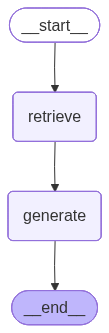

In [31]:
from  IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

#### Generate with StateGraph

In [22]:
start_state = RAGState(question=example_question)
final_state = graph.invoke(start_state)

INFO:httpx:HTTP Request: POST http://127.0.0.1:8321/v1/vector_stores/vs_62b774e4-1dda-4203-a8c7-18db45b0e947/search "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:8321/v1/chat/completions "HTTP/1.1 200 OK"


In [23]:
final_state

{'question': 'What was the total revenue for year 2024?',
 'retrieved_documents': ['h q u a r t e r t o a s s e s s t h e a d e q u a c y o f t h e e s t i m a t e s . I f t h e e s t i m a t e s w e r e\nc h a n g e d b y 1 0 p e r c e n t i n 2 0 2 4 , t h e i m p a c t o n n e t i n c o m e w o u l d h a v e b e e n $ 3 1 m i l l i o n .\nC o s t s t o C o m p l e t e S e r v i c e C o n t r a c t s\nW e e n t e r i n t o n u m e r o u s s e r v i c e c o n t r a c t s t h r o u g h o u r s e r v i c e s b u s i n e s s e s . D u r i n g t h e c o n t r a c t u a l p e r i o d ',
  '- t o - Y r .\nP e r c e n t\nC h a n g e\nI n t e l l e c t u a l p r o p e r t y i n c o m e\n( 1 ) ( 2 )\n$ 3 2 9 $ 3 7 4 ( 1 2 . 1 ) %\nC u s t o m d e v e l o p m e n t i n c o m e 6 6 7 4 8 5 3 7 . 5\nT o t a l $ 9 9 6 $ 8 6 0 1 5 . 9 %\n( 1 ) I n c l u d e s l i c e n s i n g , r o y a l t y - b a s e d f e e s a n d s a l e s .\n( 2 ) P r i o r - y e a r a m o u n t s h a v e b e e n r e c l a s 

#### Generate Stream with StateGraph


In [24]:
start_state = RAGState(question=example_question)
stream = graph.stream(start_state, stream_mode="custom")

In [25]:
for chunk in stream:
    print(chunk["chunk_content"]["content"], end="")

INFO:httpx:HTTP Request: POST http://127.0.0.1:8321/v1/vector_stores/vs_62b774e4-1dda-4203-a8c7-18db45b0e947/search "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:8321/v1/chat/completions "HTTP/1.1 200 OK"


I do not have an answer to the total revenue for year 2024 as the document does not provide a clear statement of the total revenue for that specific year. The document provides various financial figures, such as intellectual property income, custom development income, and financing revenue, but it does not provide a comprehensive total revenue figure for 2024.